<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/02131.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 9.1 图像增广

In [0]:
%matplotlib inline 
import torch 
from torch import nn, optim 
from torch.utils.data import Dataset, DataLoader 
import torchvision 
from PIL import Image 
import d2l 
import time 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 9.1.1 常用的图像增广方法

In [4]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15713 (delta 0), reused 1 (delta 0), pack-reused 15708
Receiving objects: 100% (15713/15713), 159.57 MiB | 46.49 MiB/s, done.
Resolving deltas: 100% (11136/11136), done.


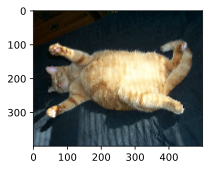

In [6]:
d2l.set_figsize()
img = Image.open('d2l-zh/img/cat1.jpg')
d2l.plt.imshow(img)

In [0]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [0]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

#### 1 翻转和裁剪

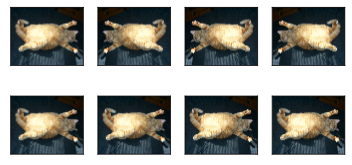

In [9]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

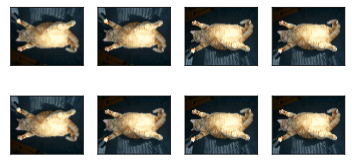

In [10]:
apply(img, torchvision.transforms.RandomVerticalFlip())

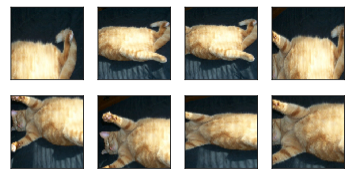

In [11]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

#### 2 颜色变化

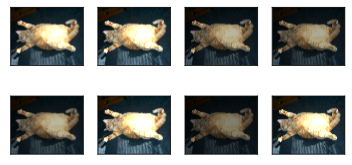

In [12]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

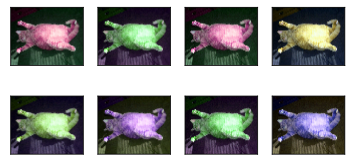

In [13]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

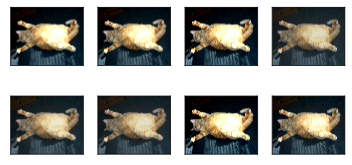

In [14]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

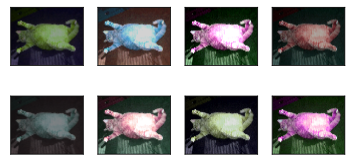

In [15]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

#### 3 叠加多个图像增广方法

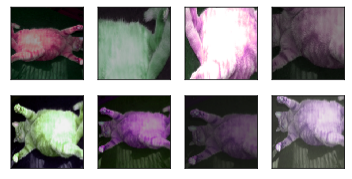

In [16]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
])
apply(img, augs)

### 9.1.2 使用图像增广训练模型

Files already downloaded and verified


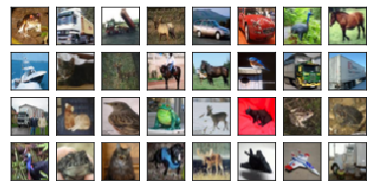

In [18]:
all_images = torchvision.datasets.CIFAR10(train=True, root='~/Datasets/CIFAR', download=True)
show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [0]:
flip_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.ToTensor()
])

no_aug = torchvision.transforms.Compose({
    torchvision.transforms.ToTensor()
})

In [0]:
num_workers = 4 
def load_cifar10(is_train, augs, batch_size, root='~/Datasets/CIFAR'):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

#### 1 使用图像增广训练模型

In [0]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print('training on ', device)
    batch_count = 0 
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1 
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' 
         % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [0]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [29]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.3928, train acc 0.495, test acc 0.435, time 21.1 sec
epoch 2, loss 0.5094, train acc 0.639, test acc 0.528, time 21.1 sec
epoch 3, loss 0.2865, train acc 0.695, test acc 0.561, time 21.2 sec
epoch 4, loss 0.1908, train acc 0.734, test acc 0.672, time 21.4 sec
epoch 5, loss 0.1345, train acc 0.766, test acc 0.649, time 21.5 sec
epoch 6, loss 0.1035, train acc 0.785, test acc 0.692, time 21.5 sec
epoch 7, loss 0.0805, train acc 0.805, test acc 0.732, time 21.6 sec
epoch 8, loss 0.0634, train acc 0.823, test acc 0.749, time 21.7 sec
epoch 9, loss 0.0534, train acc 0.834, test acc 0.755, time 21.6 sec
epoch 10, loss 0.0434, train acc 0.849, test acc 0.740, time 21.9 sec
